# Initial Data Exploration

In [56]:
#!pip install rapidfuzz
#!pip install transformers
#!pip install datasets
#!pip install scikit-learn

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer
import string
import numpy as np
import re
from rapidfuzz import fuzz
from datasets import Dataset
from sklearn.metrics import accuracy_score

os.environ["WANDB_DISABLED"] = "true"

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [31]:
df1 = pd.read_csv("20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")
df2 = pd.read_csv("Bitext_Sample_Customer_Service_Training_Dataset.csv")

print("Dataset 1 shape:", df1.shape)
print("Dataset 2 shape:", df2.shape)

Dataset 1 shape: (21534, 4)
Dataset 2 shape: (8175, 4)


In [32]:
df1.info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21534 entries, 0 to 21533
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   flags      21534 non-null  object
 1   utterance  21534 non-null  object
 2   category   21534 non-null  object
 3   intent     21534 non-null  object
dtypes: object(4)
memory usage: 673.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8175 entries, 0 to 8174
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   flags      8175 non-null   object
 1   utterance  8175 non-null   object
 2   category   8175 non-null   object
 3   intent     8175 non-null   object
dtypes: object(4)
memory usage: 255.6+ KB


In [33]:
df1.isnull().sum()
df2.isnull().sum()

,0
flags,0
utterance,0
category,0
intent,0


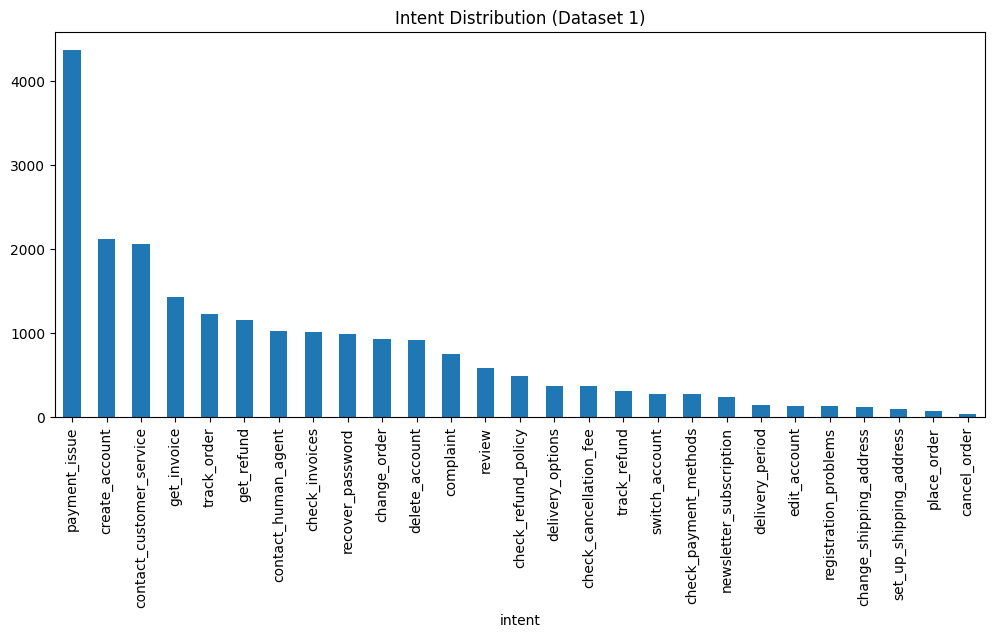

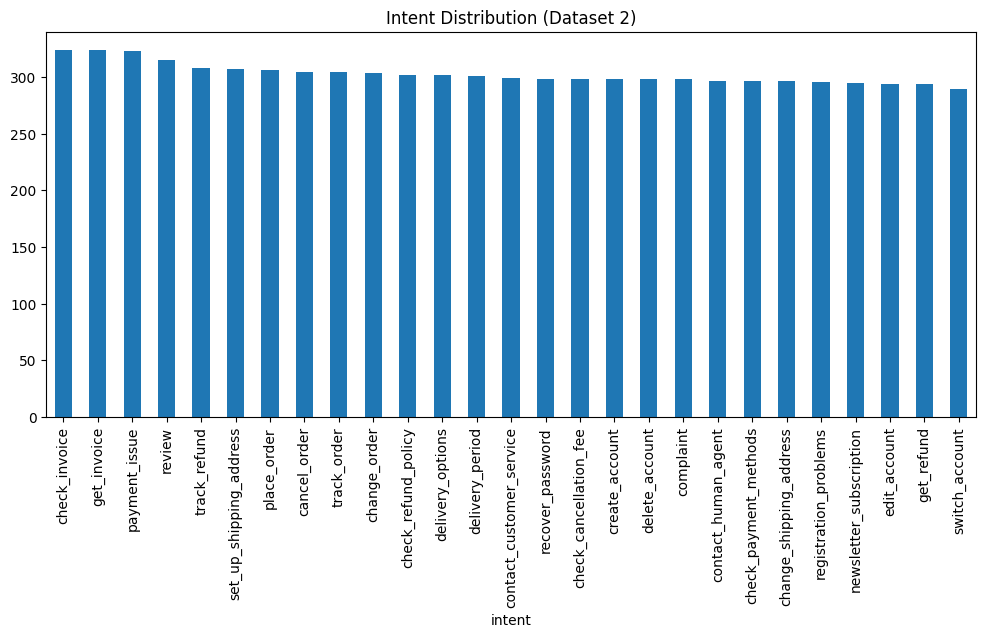

In [4]:
import matplotlib.pyplot as plt

df1['intent'].value_counts().plot(kind='bar', figsize=(12,5), title="Intent Distribution (Dataset 1)")
plt.show()

df2['intent'].value_counts().plot(kind='bar', figsize=(12,5), title="Intent Distribution (Dataset 2)")
plt.show()

In [34]:
print("Duplicates in Dataset 1:", df1.duplicated().sum())
print("Duplicates in Dataset 2:", df2.duplicated().sum())

Duplicates in Dataset 1: 12
Duplicates in Dataset 2: 0


In [35]:
df1.duplicated().sum(), df2.duplicated().sum()

(np.int64(12), np.int64(0))

In [36]:
df = pd.concat([df1, df2], ignore_index=True).drop_duplicates()
print("Combined shape:", df.shape)

Combined shape: (29637, 4)


# Preprocessing

In [8]:
df.head()

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


In [38]:
df['tokens'] = df['utterance'].apply(lambda x: word_tokenize(x.lower()))
df['pos_tags'] = df['tokens'].apply(nltk.pos_tag)

lemmatizer = WordNetLemmatizer()
df['lemmas'] = df['tokens'].apply(lambda tokns: [lemmatizer.lemmatize(t) for t in tokns])

stop_words = set(stopwords.words('english'))
df['clean_tokens'] = df['lemmas'].apply(lambda toks: [t for t in toks if t not in stop_words])
df['clean_text'] = df['clean_tokens'].apply(lambda toks: " ".join(toks))

df[['utterance', 'tokens', 'lemmas', 'clean_text']].head()

,utterance,tokens,lemmas,clean_text
0,"I don't have an online account, what do I have...","[i, do, n't, have, an, online, account, ,, wha...","[i, do, n't, have, an, online, account, ,, wha...","n't online account , register ?"
1,can you tell me if i can regisger two accounts...,"[can, you, tell, me, if, i, can, regisger, two...","[can, you, tell, me, if, i, can, regisger, two...",tell regisger two account single email address ?
2,"I have no online account, open one, please","[i, have, no, online, account, ,, open, one, ,...","[i, have, no, online, account, ,, open, one, ,...","online account , open one , please"
3,"could you ask an agent how to open an account,...","[could, you, ask, an, agent, how, to, open, an...","[could, you, ask, an, agent, how, to, open, an...","could ask agent open account , please ?"
4,"i want an online account, create one","[i, want, an, online, account, ,, create, one]","[i, want, an, online, account, ,, create, one]","want online account , create one"


In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

expl = df['utterance'].iloc[0]
print("Original:", expl)
print("NLTK tokens:", df['tokens'].iloc[0])
print("BERT tokens:", tokenizer.tokenize(expl))

Original: I don't have an online account, what do I have to do to register?
NLTK tokens: ['i', 'do', "n't", 'have', 'an', 'online', 'account', ',', 'what', 'do', 'i', 'have', 'to', 'do', 'to', 'register', '?']
BERT tokens: ['i', 'don', "'", 't', 'have', 'an', 'online', 'account', ',', 'what', 'do', 'i', 'have', 'to', 'do', 'to', 'register', '?']


Classical NLP preprocessing (tokenization, lemmatization, POS tagging) is useful for rule-based systems, keyword extraction, and understanding linguistic structure. However, transformer models like BERT do not require these steps because they learn contextual representations directly from raw text. For educational purposes, this project demonstrates both approaches to highlight the evolution of NLP pipelines and the advantages of modern transformer-based preprocessing.

# Model Development

In [61]:
X = df['utterance']
Y = df['intent']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=123
)

intent_keywords = {
    "create_account": ["create", "open", "new", "register", "signup", "setup", "account"],
    "delete_account": ["delete", "close", "remove", "cancel", "account"],
    "edit_account": ["edit", "update", "change", "modify", "account"],
    "recover_password": ["forgot", "reset", "recover", "lost", "password"],
    "place_order": ["place", "order", "buy", "purchase"],
    "cancel_order": ["cancel", "order", "stop"],
    "change_order": ["change", "modify", "edit", "order"],
    "track_order": ["track", "order", "status"],
    "get_invoice": ["get", "download", "send", "invoice"],
    "check_invoice": ["check", "view", "see", "invoice"],
    "payment_issue": ["payment", "problem", "decline", "failed", "billing"],
    "contact_customer_service": ["contact", "support", "customer", "service"],
    "contact_human_agent": ["human", "agent", "person", "live"],
    "complaint": ["complaint", "bad", "unhappy", "dissatisfied"],
    "get_refund": ["refund", "money", "return"],
    "track_refund": ["refund", "status", "track"],
    "delivery_options": ["delivery", "shipping", "option", "method"],
    "delivery_period": ["delivery", "shipping", "time", "receive"],
    "set_up_shipping_address": ["setup", "add", "new", "shipping", "address"],
    "change_shipping_address": ["change", "edit", "update", "address"],
    "newsletter_subscription": ["newsletter", "subscribe", "unsubscribe", "mailing"],
    "review": ["review", "rate", "rating", "feedback"]
}

intent_regex = {
    "cancel_order": [
        r"cancel.*order",
        r"stop.*order",
        r"order.*cancel"
    ],
    "track_order": [
        r"track.*order",
        r"where.*order",
        r"order.*status"
    ],
    "get_refund": [
        r"refund",
        r"money.*back",
        r"return.*money"
    ],
    "recover_password": [
        r"reset.*password",
        r"forgot.*password",
        r"recover.*password"
    ]
}


In [62]:
def extract_main_verbs(pos_tags):
    return [word for word, tag in pos_tags if tag.startswith("VB")]

df['verbs'] = df['pos_tags'].apply(extract_main_verbs)

In [64]:
def rule_based_intent(text, verbs=None):
    best_intent = "unknown"
    best_score = 0

    for intent, keywords in intent_keywords.items():
        verb_score = 0

        exact_score = sum(1 for kw in keywords if kw in text)
        fuzzy_score = sum(
            1 for kw in keywords if fuzz.partial_ratio(kw, text) > 80
        )
        if verbs:
            verb_score = sum(1 for v in verbs if v in keywords)

        total_score = exact_score + fuzzy_score + verb_score
        if total_score > best_score:
            best_score = total_score
            best_intent = intent

    for intent, patterns in intent_regex.items():
        for pattern in patterns:
            if re.search(pattern, text):
                return intent

    return best_intent


preds_r = [
    rule_based_intent(text, verbs=df.loc[idx, 'verbs'])
    for idx, text in X_test.items()
]

print("Rule-Based Accuracy:", accuracy_score(Y_test, preds_r))
print(classification_report(Y_test, preds_r, labels=sorted(df['intent'].unique())))

Rule-Based Accuracy: 0.5435222672064778
                          precision    recall  f1-score   support

            cancel_order       1.00      0.85      0.92        68
            change_order       1.00      0.54      0.71       246
 change_shipping_address       1.00      0.04      0.07        81
  check_cancellation_fee       0.00      0.00      0.00       129
           check_invoice       0.04      0.42      0.07        65
          check_invoices       0.00      0.00      0.00       203
   check_payment_methods       0.00      0.00      0.00       113
     check_refund_policy       0.00      0.00      0.00       156
               complaint       1.00      0.31      0.47       208
contact_customer_service       0.59      0.84      0.69       471
     contact_human_agent       0.51      0.54      0.53       264
          create_account       0.69      0.93      0.80       484
          delete_account       0.71      0.94      0.81       242
        delivery_options       0.99

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])
num_labels = len(label_encoder.classes_)

dataset = Dataset.from_pandas(df[['utterance', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=123)

In [45]:
def tokenize(batch):
    return tokenizer(batch['utterance'], padding='max_length', truncation=True, max_length=64)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/23709 [00:00<?, ? examples/s]

Map:   0%|          | 0/5928 [00:00<?, ? examples/s]

In [47]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.026300,0.022827
2,0.010200,0.009245
3,0.003100,0.007877


{'eval_loss': 0.007877178490161896,
 'eval_runtime': 5.5749,
 'eval_samples_per_second': 1063.335,
 'eval_steps_per_second': 66.548,
 'epoch': 3.0}

In [68]:
preds = trainer.predict(dataset['test'])
Y_pred = np.argmax(preds.predictions, axis=1)
Y_true = preds.label_ids

print("Accuracy:", accuracy_score(Y_true, Y_pred))
print(classification_report(Y_true, Y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9986504723346828
                          precision    recall  f1-score   support

            cancel_order       1.00      1.00      1.00        66
            change_order       1.00      1.00      1.00       263
 change_shipping_address       0.99      1.00      0.99        70
  check_cancellation_fee       1.00      1.00      1.00       138
           check_invoice       0.98      0.96      0.97        57
          check_invoices       0.99      1.00      0.99       205
   check_payment_methods       1.00      1.00      1.00       113
     check_refund_policy       1.00      1.00      1.00       156
               complaint       1.00      0.99      1.00       222
contact_customer_service       1.00      1.00      1.00       433
     contact_human_agent       1.00      1.00      1.00       283
          create_account       1.00      1.00      1.00       470
          delete_account       1.00      1.00      1.00       243
        delivery_options       1.00      1.00 

In [70]:
print("Rule-Based Accuracy:", accuracy_score(Y_test, preds_r))
print("BERT's Accuracy:", accuracy_score(Y_true, Y_pred))

Rule-Based Accuracy: 0.5435222672064778
BERT's Accuracy: 0.9986504723346828


In [71]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')